# Исследование объявлений о продаже квартир

В распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## План исследования: <a id="step0"></a>
[**Шаг 1. Загрузка файла с данными и изучение информации**](#step1)

[**Шаг 2. Предобработка данных**](#step2)
    - обработка пропущенных значений
    - приведение данных к нужным типам
[**Шаг 3. Добавление подсчетов в таблицу**](#step3)
    - цена квадратного метра
    - день недели, месяц, год публикации объявления
    - этаж квартиры
    - соотношение жилой и общей площади, отношение площади кухни к общей
[**Шаг 4. Исследовательский анализ данных**](#step4)
    - построение гистограмм по параментрам: площадь, цена, число комнат, высота потолков
    - изучение времени продажи квартир
    - работа с редкими данными и выбросами
    - изучение факторов, влияющих на стоимость квартиры
    - изучение зависимости цены квадратного метра от населенного пункта
    - изучение зависимости цены квадратного метра от расстояния до центра
    - изучение сегмента недвижимости в центре
[**Шаг 5. Общий вывод**](#step5)

### Шаг 1. Загрузка файла с данными и изучение информации. <a id="step1"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/maxim/Documents/Edu/DA/Yandex/Datasets/03_real_estate_sbp/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', 50)

**Описание данных**
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

In [2]:
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [3]:
df.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
15593,20,6000000.0,45.10,2018-09-26T00:00:00,1,3.00,17.0,20.10,14,NaN,False,False,10.6,NaN,Сестрорецк,56343.0,33272.0,0.0,NaN,1.0,545.0,201.0
11833,17,8300000.0,82.20,2018-07-24T00:00:00,3,2.50,18.0,43.00,9,NaN,False,False,13.6,NaN,Санкт-Петербург,36564.0,13479.0,0.0,NaN,0.0,NaN,237.0
1801,11,2750000.0,53.00,2017-01-09T00:00:00,2,2.55,5.0,30.00,4,NaN,False,False,8.3,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,39.0
17252,16,4200000.0,56.20,2018-03-21T00:00:00,2,2.75,17.0,31.00,11,False,False,False,10.5,1.0,Колпино,28554.0,34341.0,0.0,NaN,3.0,287.0,7.0
1339,4,7850000.0,60.00,2018-03-17T00:00:00,2,3.38,7.0,33.60,3,NaN,False,False,11.2,NaN,Санкт-Петербург,26313.0,5016.0,3.0,417.0,1.0,118.0,60.0
11174,11,4150000.0,51.00,2017-10-24T00:00:00,1,2.70,5.0,30.00,3,NaN,False,False,9.0,1.0,посёлок Металлострой,26000.0,27712.0,0.0,NaN,0.0,NaN,45.0
6270,8,5650000.0,41.00,2017-09-21T00:00:00,1,2.70,18.0,20.00,13,NaN,False,False,9.5,2.0,Санкт-Петербург,37491.0,9963.0,1.0,657.0,0.0,NaN,365.0
2300,6,4500000.0,55.70,2018-03-29T00:00:00,3,NaN,5.0,36.30,3,NaN,False,False,5.7,NaN,Санкт-Петербург,36491.0,9162.0,2.0,30.0,0.0,NaN,253.0
22106,2,3577388.0,28.86,2017-06-29T00:00:00,1,2.75,14.0,18.28,9,NaN,False,False,NaN,0.0,Санкт-Петербург,18039.0,4352.0,0.0,NaN,0.0,NaN,3.0
18888,11,13000000.0,134.70,2016-05-31T00:00:00,4,2.80,5.0,71.30,4,NaN,False,False,17.6,NaN,Санкт-Петербург,21643.0,1200.0,1.0,527.0,2.0,116.0,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Выявленные проблемы:

- неинформативные названия некоторых столбцов, присутствие верхнего регистра;
- пропущенные значения;
- неверный тип данных в некоторых столбцах.

### Шаг 2. Предобработка данных <a id="step2"></a>
[*Вернуться к плану*](#step0)

Переименуем столбцы:

In [5]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [6]:
new_cols = ['total_images', 'last_price', 'total_area', 'publication_datetime', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'is_apartment', 'is_studio', 'is_open_plan', 
       'kitchen_area', 'balcony', 'locality_name', 'dist_to_airport', 'dist_to_center', 'parks_around3000', 'dist_to_park', 'ponds_around3000', 'dist_to_pond', 'publication_days']

df.set_axis(new_cols, axis='columns', inplace=True)

In [7]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'publication_datetime',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'is_studio', 'is_open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'dist_to_airport', 'dist_to_center',
       'parks_around3000', 'dist_to_park', 'ponds_around3000', 'dist_to_pond',
       'publication_days'],
      dtype='object')

In [8]:
df.head()

,total_images,last_price,total_area,publication_datetime,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balcony,locality_name,dist_to_airport,dist_to_center,parks_around3000,dist_to_park,ponds_around3000,dist_to_pond,publication_days
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Проверяем пропуски:

In [9]:
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
publication_datetime        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
is_studio                   0
is_open_plan                0
kitchen_area             2278
balcony                 11519
locality_name              49
dist_to_airport          5542
dist_to_center           5519
parks_around3000         5518
dist_to_park            15620
ponds_around3000         5518
dist_to_pond            14589
publication_days         3181
dtype: int64

In [10]:
df.isnull().sum().sort_values() / df.shape[0] * 100

total_images             0.000000
is_open_plan             0.000000
floor                    0.000000
rooms                    0.000000
is_studio                0.000000
total_area               0.000000
last_price               0.000000
publication_datetime     0.000000
locality_name            0.206760
floors_total             0.362885
living_area              8.029875
kitchen_area             9.612220
publication_days        13.422507
ponds_around3000        23.283683
parks_around3000        23.283683
dist_to_center          23.287902
dist_to_airport         23.384953
ceiling_height          38.799105
balcony                 48.605426
dist_to_pond            61.559559
dist_to_park            65.909954
is_apartment            88.290645
dtype: float64

**Населенный пункт, Количество этажей в доме**. Пропущенных значений немного: 0.2% и 0.36% соответственно. Удаляем.

In [11]:
df = df.dropna(subset=['locality_name'])

In [12]:
df = df.dropna(subset=['floors_total'])

In [13]:
df.isnull().sum().sort_values()

total_images                0
locality_name               0
is_open_plan                0
floor                       0
floors_total                0
is_studio                   0
rooms                       0
publication_datetime        0
total_area                  0
last_price                  0
living_area              1865
kitchen_area             2222
publication_days         3171
parks_around3000         5500
ponds_around3000         5500
dist_to_center           5501
dist_to_airport          5524
ceiling_height           9084
balcony                 11475
dist_to_pond            14529
dist_to_park            15535
is_apartment            20805
dtype: int64

Пропуски в жилой площади и площади кухни заменим на основании отношения этих параметров к общей площади с учетом медианных значений для разного количества комнат в квартирах.

In [14]:
living_area_ratio = (df['living_area'] / df['total_area']).groupby(df['rooms']).median()
living_area_ratio

rooms
0     0.689655
1     0.482638
2     0.585470
3     0.631833
4     0.659789
5     0.651842
6     0.679509
7     0.681670
8     0.688475
9     0.628251
10    0.653103
11    0.710093
12    0.455222
14    0.648695
15    0.693220
16    0.666667
19    0.706086
dtype: float64

In [15]:
df.loc[df['living_area'].isnull(), 'living_area'] = df.loc[df['living_area'].isnull(), 'rooms'].apply(lambda x: x * living_area_ratio[x])

In [16]:
kitchen_area_ratio = (df['kitchen_area'] / df['total_area']).groupby(df['rooms']).median()
kitchen_area_ratio

rooms
0          NaN
1     0.247779
2     0.161034
3     0.128496
4     0.112245
5     0.105386
6     0.098853
7     0.083717
8     0.109170
9     0.049620
10    0.091624
11    0.066855
12    0.124444
14    0.075636
15    0.169492
16    0.048148
19    0.073679
dtype: float64

In [17]:
df.loc[df['kitchen_area'].isnull(), 'kitchen_area'] = df.loc[df['kitchen_area'].isnull(), 'rooms'].apply(lambda z: z * kitchen_area_ratio[z])

In [18]:
df.isnull().sum().sort_values()

total_images                0
locality_name               0
is_open_plan                0
floor                       0
living_area                 0
floors_total                0
is_studio                   0
rooms                       0
publication_datetime        0
total_area                  0
last_price                  0
kitchen_area              194
publication_days         3171
parks_around3000         5500
ponds_around3000         5500
dist_to_center           5501
dist_to_airport          5524
ceiling_height           9084
balcony                 11475
dist_to_pond            14529
dist_to_park            15535
is_apartment            20805
dtype: int64

Оставшиеся пропуски появились из-за отсутствующих данных по площади кухни для квартир с нулем комнат. Заменим медианой для однокомнатных квартир.

In [86]:
df.loc[df['kitchen_area'].isnull(), 'kitchen_area'] = df.loc[df['kitchen_area'].isnull(), 'rooms'].apply(lambda y: y * 0.247779)

Пропуски в длительности публикации могли появиться, если объявления еще активны, квартиры проданы меньше, чем за день или технической ошибки. Произведем замену на значение-маркер - 0.

In [20]:
df['publication_days'] = df['publication_days'].fillna(0)

Пропуски в высоте потолков меняем на медиану, так как в датасете нет информации по серии домов, чтобы получить определенное значение высоты потолков.

In [21]:
сeiling_height_median = df['ceiling_height'].median()
сeiling_height_median

2.65

In [22]:
df['ceiling_height'].fillna(2.65, inplace=True)

In [23]:
df.isnull().sum().sort_values()

total_images                0
locality_name               0
kitchen_area                0
is_open_plan                0
floor                       0
living_area                 0
is_studio                   0
ceiling_height              0
rooms                       0
publication_datetime        0
total_area                  0
last_price                  0
floors_total                0
publication_days            0
parks_around3000         5500
ponds_around3000         5500
dist_to_center           5501
dist_to_airport          5524
balcony                 11475
dist_to_pond            14529
dist_to_park            15535
is_apartment            20805
dtype: int64

In [24]:
df.isnull().sum().sort_values()

total_images                0
locality_name               0
kitchen_area                0
is_open_plan                0
floor                       0
living_area                 0
is_studio                   0
ceiling_height              0
rooms                       0
publication_datetime        0
total_area                  0
last_price                  0
floors_total                0
publication_days            0
parks_around3000         5500
ponds_around3000         5500
dist_to_center           5501
dist_to_airport          5524
balcony                 11475
dist_to_pond            14529
dist_to_park            15535
is_apartment            20805
dtype: int64

Посмотрим на количество пропущенных значений для Санкт-Петербурга, так как именно эти данные будут нужны в исследовании:

In [25]:
len(df.query("dist_to_center.isna() and locality_name == 'Санкт-Петербург'"))

60

Пропусков мало. Добавим столбец с расстоянием до центра в километрах. Заменим пропуски на медианное значение именно для Санкт-Петербурга:

In [26]:
df['dist_to_center_km'] = round(df['dist_to_center'] / 1000)

In [27]:
df.head()

,total_images,last_price,total_area,publication_datetime,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balcony,locality_name,dist_to_airport,dist_to_center,parks_around3000,dist_to_park,ponds_around3000,dist_to_pond,publication_days,dist_to_center_km
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,NaN,False,False,25.000000,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0.0,16.0
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.600000,1,NaN,False,False,11.000000,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,19.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.300000,4,NaN,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,14.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,1.895498,9,NaN,False,False,0.385489,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,7.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,NaN,False,False,41.000000,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,8.0


In [28]:
df_spb_for_median = df.query("locality_name == 'Санкт-Петербург'").reset_index(drop=True)

In [29]:
dist_to_center_median = df_spb_for_median['dist_to_center_km'].median()
dist_to_center_median

12.0

In [30]:
df['dist_to_center_km'] = df['dist_to_center_km'].fillna(12)
df['dist_to_center_km'].isna().sum()

0

In [31]:
df['is_apartment'] = df['is_apartment'].fillna(0)
df['is_apartment'].isna().sum()

0

In [32]:
df['is_apartment'].value_counts()

0       23515
True       50
Name: is_apartment, dtype: int64

In [33]:
df.isnull().sum().sort_values()

total_images                0
locality_name               0
kitchen_area                0
publication_days            0
is_studio                   0
is_apartment                0
floor                       0
is_open_plan                0
floors_total                0
ceiling_height              0
rooms                       0
publication_datetime        0
total_area                  0
last_price                  0
living_area                 0
dist_to_center_km           0
parks_around3000         5500
ponds_around3000         5500
dist_to_center           5501
dist_to_airport          5524
balcony                 11475
dist_to_pond            14529
dist_to_park            15535
dtype: int64

In [34]:
df['balcony'].value_counts()

1.0    4187
0.0    3680
2.0    3656
5.0     304
4.0     182
3.0      81
Name: balcony, dtype: int64

Пропусков в остальных столбцах слишком много для замены одним значением и эти столбцы не будут использоваться в нашем исследовании. Отсутствуют почти половина значений количества балконов. С учетом того, что значения с нулём балконов есть в датасете, нельзя со 100% уверенностью сказать, что все пропуски значат и могут быть заменены на ноль.\
Пропуски скорее всего возникли из-за того, что некоторые значения не были внесены пользователями.

**Дубликаты не выявлены:**

In [35]:
df.duplicated().sum()

0

Посмотрим на значения столбца с названием населенного пункта:

In [36]:
df['locality_name'].value_counts() / len(df) * 100

Санкт-Петербург                  66.416295
посёлок Мурино                    2.206662
посёлок Шушары                    1.862932
Всеволожск                        1.688945
Пушкин                            1.565882
                                   ...    
деревня Пижма                     0.004244
поселок Пансионат Зелёный Бор     0.004244
деревня Иссад                     0.004244
деревня Чудской Бор               0.004244
поселок Кирпичное                 0.004244
Name: locality_name, Length: 364, dtype: float64

Видим значительно преобладающую долю квартир в СПб - 66%.

**Перейдем к замене типов данных на подходящие:**

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
publication_datetime    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null object
is_studio               23565 non-null bool
is_open_plan            23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 12090 non-null float64
locality_name           23565 non-null object
dist_to_airport         18041 non-null float64
dist_to_center          18064 non-null float64
parks_around3000        18065 non-null float64
dist_to_park            8030 non-null float64
ponds_around30

Необходимо заменить тип данных в publication_datetime - на datetime, чтобы в дальнейшем можно было работать с такими данными.

In [38]:
df['publication_datetime'] = pd.to_datetime(df['publication_datetime'], format='%Y-%m-%dT%H:%M:%S')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
publication_datetime    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null object
is_studio               23565 non-null bool
is_open_plan            23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 12090 non-null float64
locality_name           23565 non-null object
dist_to_airport         18041 non-null float64
dist_to_center          18064 non-null float64
parks_around3000        18065 non-null float64
dist_to_park            8030 non-null float64
ponds_

### Вывод
Подготовили данные к анализу: переименовали столбцы, обработали пропуски, заменили тип данных.

### Шаг 3. Добавление подсчетов в таблицу <a id="step3"></a>
[*Вернуться к плану*](#step0)

Добавим в датасет цену квадратного метра, день недели, месяц и год публикации объявления:

In [40]:
df['price_per_meter'] = df['last_price'] / df['total_area']

In [41]:
df['day_of_week'] = df['publication_datetime'].dt.weekday

In [42]:
df['month'] = df['publication_datetime'].dt.month

In [43]:
df['year'] = df['publication_datetime'].dt.year

In [44]:
df.head()

,total_images,last_price,total_area,publication_datetime,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balcony,locality_name,dist_to_airport,dist_to_center,parks_around3000,dist_to_park,ponds_around3000,dist_to_pond,publication_days,dist_to_center_km,price_per_meter,day_of_week,month,year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,0,False,False,25.000000,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0.0,16.0,120370.370370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,0,False,False,11.000000,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,19.0,82920.792079,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,0,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,14.0,92785.714286,3,8,2015
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,1.895498,9,0,False,False,0.385489,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,7.0,408176.100629,4,7,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,0,False,False,41.000000,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,8.0,100000.000000,1,6,2018


Проведем категоризацию этажей. Напишем для этого функцию:

In [45]:
def floor_cat(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

In [46]:
df['floor_cat'] = df.apply(floor_cat, axis=1)

In [47]:
df['living_to_total_area'] = df['living_area'] / df['total_area']
df['kitchen_to_total_area'] = df['kitchen_area'] / df['total_area']

In [48]:
df.head()

,total_images,last_price,total_area,publication_datetime,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balcony,locality_name,dist_to_airport,dist_to_center,parks_around3000,dist_to_park,ponds_around3000,dist_to_pond,publication_days,dist_to_center_km,price_per_meter,day_of_week,month,year,floor_cat,living_to_total_area,kitchen_to_total_area
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,0,False,False,25.000000,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0.0,16.0,120370.370370,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,0,False,False,11.000000,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,19.0,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,0,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,14.0,92785.714286,3,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,1.895498,9,0,False,False,0.385489,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,7.0,408176.100629,4,7,2015,другой,0.011921,0.002424
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,0,False,False,41.000000,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,8.0,100000.000000,1,6,2018,другой,0.320000,0.410000


Для наглядности оставим один знак после запятой у значений с типом данных float64:

In [49]:
pd.options.display.float_format = '{:.1f}'.format

In [50]:
df.head()

,total_images,last_price,total_area,publication_datetime,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balcony,locality_name,dist_to_airport,dist_to_center,parks_around3000,dist_to_park,ponds_around3000,dist_to_pond,publication_days,dist_to_center_km,price_per_meter,day_of_week,month,year,floor_cat,living_to_total_area,kitchen_to_total_area
0,20,13000000.0,108.0,2019-03-07,3,2.7,16.0,51.0,8,0,False,False,25.0,nan,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0.0,16.0,120370.4,3,3,2019,другой,0.5,0.2
1,7,3350000.0,40.4,2018-12-04,1,2.6,11.0,18.6,1,0,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,nan,0.0,nan,81.0,19.0,82920.8,1,12,2018,первый,0.5,0.3
2,10,5196000.0,56.0,2015-08-20,2,2.6,5.0,34.3,4,0,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,14.0,92785.7,3,8,2015,другой,0.6,0.1
3,0,64900000.0,159.0,2015-07-24,3,2.6,14.0,1.9,9,0,False,False,0.4,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,7.0,408176.1,4,7,2015,другой,0.0,0.0
4,2,10000000.0,100.0,2018-06-19,2,3.0,14.0,32.0,13,0,False,False,41.0,nan,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,8.0,100000.0,1,6,2018,другой,0.3,0.4


### Шаг 4. Исследовательский анализ данных <a id="step4"></a>
[*Вернуться к плану*](#step0)

Посмотрим на следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы.

In [51]:
df[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,23565.0,23565.0,23565.0,23565.0
mean,60.3,6540058.3,2.1,2.7
std,35.7,10910934.7,1.1,1.0
min,12.0,12190.0,0.0,1.0
25%,40.0,3400000.0,1.0,2.6
50%,52.0,4646000.0,2.0,2.6
75%,69.7,6790000.0,3.0,2.7
max,900.0,763000000.0,19.0,100.0


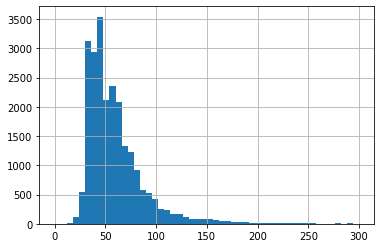

In [52]:
df['total_area'].hist(bins=50, range=(0, 300));

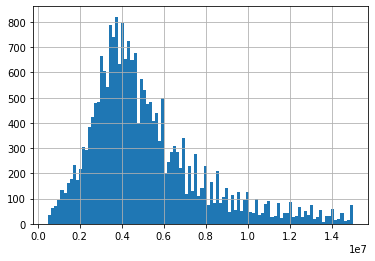

In [53]:
df['last_price'].hist(bins=100, range=(500000, 15000000));

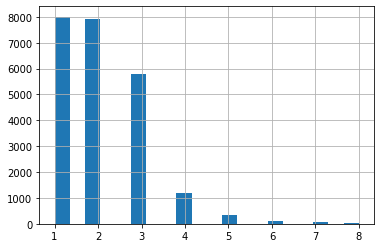

In [54]:
df['rooms'].hist(bins=20, range=(1, 8));

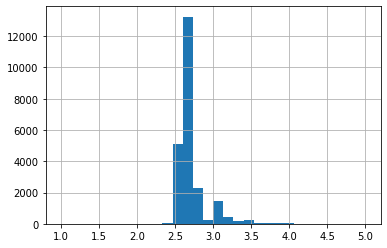

In [55]:
df['ceiling_height'].hist(bins=30, range=(1, 5));

Значения и их распределение выглядят вполне нормально. У большинства квартир 1-3 комнаты, площадь от 30 до 60 м2, стоимость 2-5 млн руб, высота потолков 2,5-2,8 м.  Есть вопросы к выбросам в виде максимльной площади и минимальной высоты потолков, количества комнат, минимальной цены.

Изучим время продажи квартиры:

In [56]:
df['publication_days'].describe()

count   23565.0
mean      156.4
std       213.5
min         0.0
25%        22.0
50%        73.0
75%       198.0
max      1580.0
Name: publication_days, dtype: float64

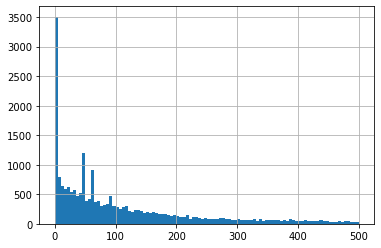

In [57]:
df['publication_days'].hist(bins=100, range=(0, 500));

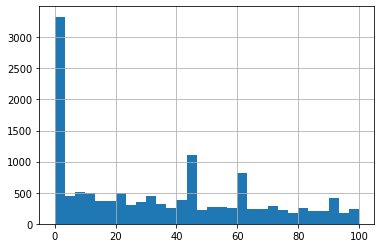

In [58]:
df['publication_days'].hist(bins=30, range=(0, 100));

- Среднее значение срока продажи квартиры - 156 дней, 5 месяцев.
- Медианное значение вдвое меньне - 73 дня, 2,5 месяца. Это нам говорит о наличии выбросов, когда квартиру не могут продать почти 5 лет (судя по максимальному значению) или же объявления остаются на сайте после продажи.
- на графики видны всплески в районе 45, 60 и 90 дней. Можно предположить, что определенный тип публикаций, который расчитан на 1,5, 2 и 3 месяца размещения, а далее автоматически закрывается.

Из данных по квантилям можно сказать, что продажу квартиры за 3 недели можно считать быстрой сделкой, 5 месяцев - нормальной, а более 7 месяцев - долгой. 

Уберем редкие и выбивающиеся значения и построим графики box plot. Для этого напишем функцию, которая будет убирать выбросы, выводить на экран график box plot, а также среднее значение до и после фильтрации.  

In [59]:
def delete_outliers(data, column, x, y):
    q1 = data[column].quantile(0.25)                 
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    filt_data = (data[column]>=(q1-1.5*iqr))&(data[column]<=(q3+1.5*iqr))
    data[filt_data].boxplot([column], figsize=(x, y))
    print('Среднее значение исходных данных: {:.1f}'.format(data[column].mean()))
    print('Среднее значение после фильтрации выбросов: {:.1f}'.format(data[filt_data][column].mean()))

Среднее значение исходных данных: 156.4
Среднее значение после фильтрации выбросов: 103.7


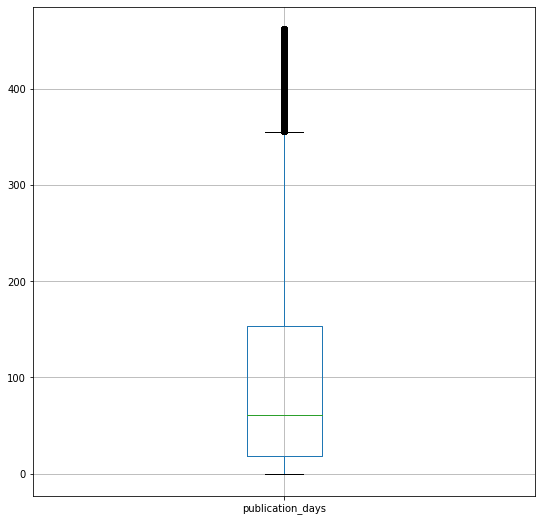

In [60]:
delete_outliers(df, 'publication_days', 9, 9)

Среднее значение исходных данных: 6540058.3
Среднее значение после фильтрации выбросов: 4837114.5


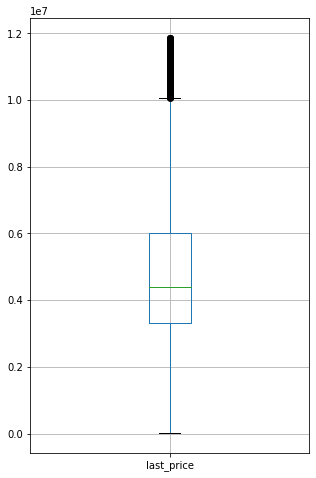

In [61]:
delete_outliers(df, 'last_price', 5, 8)

Среднее значение исходных данных: 2.1
Среднее значение после фильтрации выбросов: 2.0


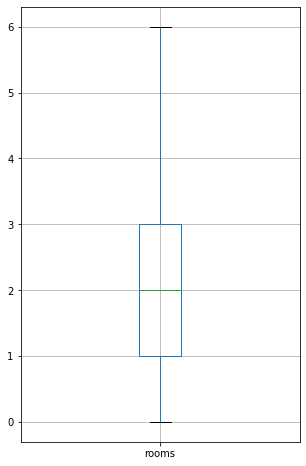

In [62]:
delete_outliers(df, 'rooms', 5, 8)

Среднее значение исходных данных: 2.7
Среднее значение после фильтрации выбросов: 2.6


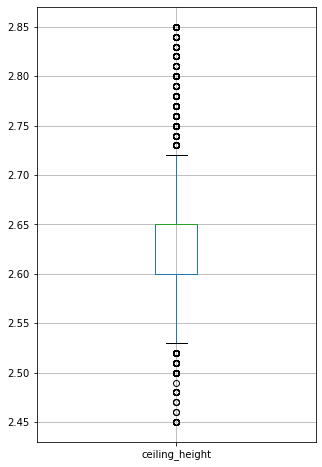

In [63]:
delete_outliers(df, 'ceiling_height', 5, 8)

**Вывод**: фильтрация помогла нам избавиться от влияния выбросов на средние значения. Редкие значения сильно влияли на показатели срока продажи квартиры и общей стоимости.

Проверим наличие корреляции стоимости квартиры от квадратного метра, числа комнат, удалённости от центра. Для этого нам нужно записать отфильтрованные данные в датасет, чтобы в дальнейшем проводить точные расчеты.

In [64]:
def boxplot_limits(column):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_line = q1 - 1.5 * iqr
    upper_line = q3 + 1.5 * iqr
    if lower_line < df[column].min():
        lower_line = df[column].min()
    if upper_line > df[column].max():
        upper_line = df[column].max()
    return [lower_line, upper_line]

In [65]:
boxplot_limits('last_price') #проверяем работу функции

[12190.0, 11875000.0]

Добавим столбец с указанием наличия выбросов за верхнюю границу в виде булева значения и сохраним фильтрованные данные в новый датасет:

In [66]:
df[['publication_days', 'last_price', 'rooms', 'ceiling_height']].describe()

,publication_days,last_price,rooms,ceiling_height
count,23565.0,23565.0,23565.0,23565.0
mean,156.4,6540058.3,2.1,2.7
std,213.5,10910934.7,1.1,1.0
min,0.0,12190.0,0.0,1.0
25%,22.0,3400000.0,1.0,2.6
50%,73.0,4646000.0,2.0,2.6
75%,198.0,6790000.0,3.0,2.7
max,1580.0,763000000.0,19.0,100.0


In [67]:
df['publication_days_filt'] = df['publication_days'] > boxplot_limits('publication_days')[1]

In [68]:
df['last_price_filt'] = df['last_price'] > boxplot_limits('last_price')[1]

In [69]:
df['rooms_filt'] = df['rooms'] > boxplot_limits('rooms')[1]

In [70]:
df['ceiling_height_filt'] = df['ceiling_height'] > boxplot_limits('ceiling_height')[1]

In [71]:
df_filt = df[(df['publication_days_filt'] == False) & 
     (df['last_price_filt'] == False) &
     (df['rooms_filt'] == False) &
     (df['ceiling_height_filt'] == False)].reset_index(drop=True)

In [72]:
df_filt.head(10)

,total_images,last_price,total_area,publication_datetime,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balcony,locality_name,dist_to_airport,dist_to_center,parks_around3000,dist_to_park,ponds_around3000,dist_to_pond,publication_days,dist_to_center_km,price_per_meter,day_of_week,month,year,floor_cat,living_to_total_area,kitchen_to_total_area,publication_days_filt,last_price_filt,rooms_filt,ceiling_height_filt
0,7,3350000.0,40.4,2018-12-04,1,2.6,11.0,18.6,1,0,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,nan,0.0,nan,81.0,19.0,82920.8,1,12,2018,первый,0.5,0.3,False,False,False,False
1,10,2890000.0,30.4,2018-09-10,1,2.6,12.0,14.4,5,0,False,False,9.1,nan,городской посёлок Янино-1,nan,nan,nan,nan,nan,nan,55.0,12.0,95065.8,0,9,2018,другой,0.5,0.3,False,False,False,False
2,6,3700000.0,37.3,2017-11-02,1,2.6,26.0,10.6,6,0,False,False,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,nan,0.0,nan,155.0,19.0,99195.7,3,11,2017,другой,0.3,0.4,False,False,False,False
3,5,7915000.0,71.6,2019-04-18,2,2.6,24.0,1.2,22,0,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,nan,0.0,nan,0.0,12.0,110544.7,3,4,2019,другой,0.0,0.3,False,False,False,False
4,20,2900000.0,33.2,2018-05-23,1,2.6,27.0,15.4,26,0,False,False,8.8,nan,посёлок Мурино,nan,nan,nan,nan,nan,nan,189.0,12.0,87454.8,2,5,2018,другой,0.5,0.3,False,False,False,False
5,18,5400000.0,61.0,2017-02-26,3,2.5,9.0,43.6,7,0,False,False,6.5,2.0,Санкт-Петербург,50898.0,15008.0,0.0,nan,0.0,nan,289.0,15.0,88524.6,6,2,2017,другой,0.7,0.1,False,False,False,False
6,5,5050000.0,39.6,2017-11-16,1,2.7,12.0,20.3,3,0,False,False,8.5,nan,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,14.0,127525.3,3,11,2017,другой,0.5,0.2,False,False,False,False
7,9,3300000.0,44.0,2018-08-27,2,2.6,5.0,31.0,4,False,False,False,6.0,1.0,Ломоносов,48252.0,51677.0,0.0,nan,0.0,nan,7.0,52.0,75000.0,0,8,2018,другой,0.7,0.1,False,False,False,False
8,10,3890000.0,54.0,2016-06-30,2,2.6,5.0,30.0,5,0,False,False,9.0,0.0,Сертолово,nan,nan,nan,nan,nan,nan,90.0,12.0,72037.0,3,6,2016,последний,0.6,0.2,False,False,False,False
9,20,3550000.0,42.8,2017-07-01,2,2.6,5.0,27.0,5,0,False,False,5.2,1.0,Петергоф,37868.0,33058.0,1.0,294.0,3.0,298.0,366.0,33.0,82943.9,5,7,2017,последний,0.6,0.1,False,False,False,False


In [73]:
df_filt[['last_price', 'total_area', 'rooms', 'dist_to_center']].corr()

,last_price,total_area,rooms,dist_to_center
last_price,1.0,0.7,0.4,-0.3
total_area,0.7,1.0,0.8,-0.1
rooms,0.4,0.8,1.0,-0.0
dist_to_center,-0.3,-0.1,-0.0,1.0


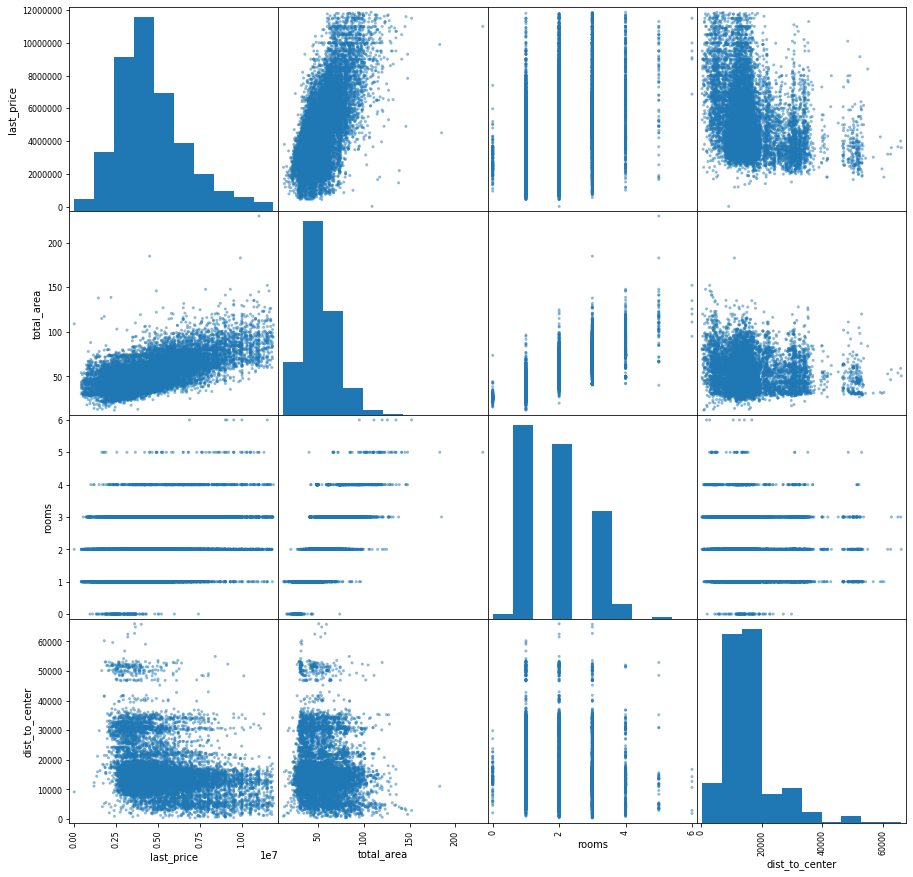

In [74]:
pd.plotting.scatter_matrix(df_filt[['last_price', 'total_area', 'rooms', 'dist_to_center']], figsize=(15, 15));

**Вывод**: просматривается корреляция стоимости квартиры от квадратных метров и количества комнат. Корреляция между стоимостью квартиры и расстоянием до центра отрицательная. Чем ближе к центру квартира, тем она дороже.

Изучим зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом, а также от даты размещения (дня недели, месяца, года).

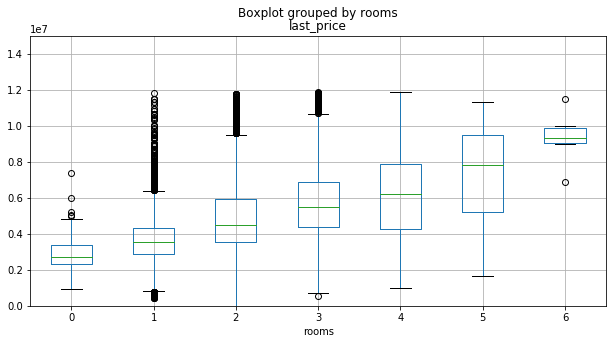

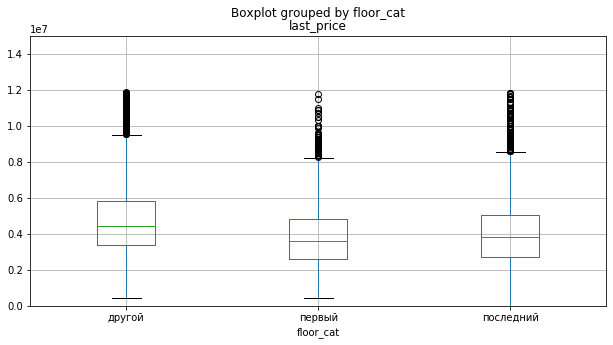

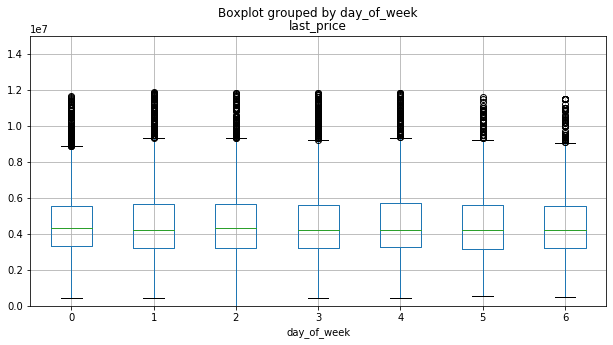

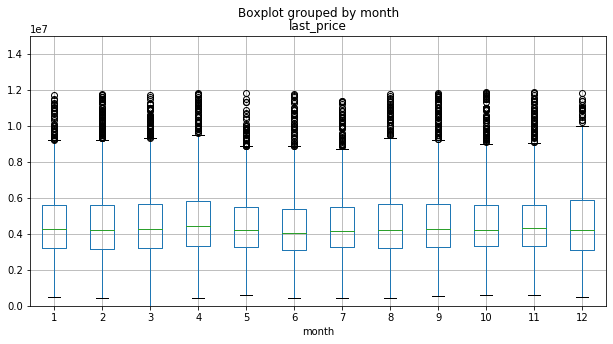

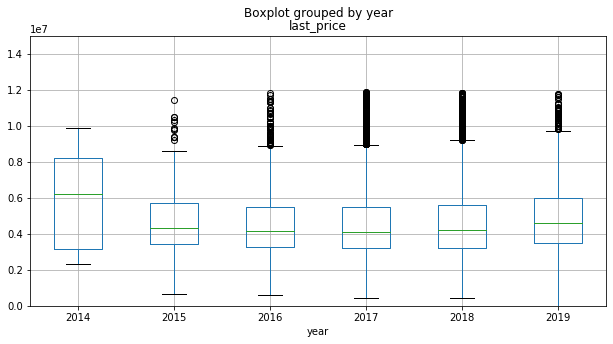

In [75]:
for column in ['rooms', 'floor_cat', 'day_of_week', 'month', 'year']:
    df_filt.boxplot('last_price', by=column, figsize=(10,5))
    plt.ylim(-500,15000000)

**Вывод**: 
- квартиры на последнем и особенно на первом этаже в среднем стоят дешевле квартир на других этажах;
- зависимость от дня недели и месяца не прослеживается, тогда как от года публикации она есть. Вероятно, на рынок недвижимости повлиял кризис 2014 года и падение реальных доходов населения. В 2019 году наметилось некоторое восстановление уровня цен. Интересно посмотреть на данные первого полугодия 2020.

Выделим 10 населенных пунктов с наибольшим числом объявлений, посчитаем среднюю цену квадратного метра.

In [76]:
top_cities = df_filt.pivot_table(index='locality_name', values='price_per_meter')
top_cities.sort_values('price_per_meter', ascending=False).head(10)

,price_per_meter
locality_name,
посёлок Лисий Нос,168706.7
Санкт-Петербург,104654.1
Сестрорецк,100367.0
деревня Мистолово,100331.5
Зеленогорск,100123.7
Кудрово,99725.5
Пушкин,99435.6
посёлок Левашово,96997.7
посёлок Репино,92727.3


**Вывод**: Самой дорогой средний метр - в элитном поселке Лисий Нос рядом с Финским заливом, а самое доступное жилье в Мурино и Репино.

Изучим предложения квартир в Санкт-Петербурге. Определим, какая область входит в центр. Перевод значений в километры выполнили в предобработке. Приведем значение в целочисленные.

In [77]:
df_spb = df_filt.query("locality_name == 'Санкт-Петербург'").reset_index(drop=True)

In [78]:
df_spb['dist_to_center_km'] = df_spb['dist_to_center_km'].astype('int', errors='ignore')

In [79]:
df_spb.head()

,total_images,last_price,total_area,publication_datetime,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balcony,locality_name,dist_to_airport,dist_to_center,parks_around3000,dist_to_park,ponds_around3000,dist_to_pond,publication_days,dist_to_center_km,price_per_meter,day_of_week,month,year,floor_cat,living_to_total_area,kitchen_to_total_area,publication_days_filt,last_price_filt,rooms_filt,ceiling_height_filt
0,5,7915000.0,71.6,2019-04-18,2,2.6,24.0,1.2,22,0,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,nan,0.0,nan,0.0,12,110544.7,3,4,2019,другой,0.0,0.3,False,False,False,False
1,18,5400000.0,61.0,2017-02-26,3,2.5,9.0,43.6,7,0,False,False,6.5,2.0,Санкт-Петербург,50898.0,15008.0,0.0,nan,0.0,nan,289.0,15,88524.6,6,2,2017,другой,0.7,0.1,False,False,False,False
2,5,5050000.0,39.6,2017-11-16,1,2.7,12.0,20.3,3,0,False,False,8.5,nan,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,14,127525.3,3,11,2017,другой,0.5,0.2,False,False,False,False
3,16,4650000.0,39.0,2017-11-18,1,2.6,14.0,20.5,5,0,False,False,7.6,1.0,Санкт-Петербург,12900.0,14259.0,1.0,590.0,1.0,296.0,19.0,14,119230.8,5,11,2017,другой,0.5,0.2,False,False,False,False
4,8,3250000.0,31.0,2017-01-27,1,2.5,5.0,19.4,2,0,False,False,5.6,1.0,Санкт-Петербург,44060.0,10842.0,1.0,759.0,0.0,nan,168.0,11,104838.7,4,1,2017,другой,0.6,0.2,False,False,False,False


In [80]:
df_spb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11165 entries, 0 to 11164
Data columns (total 34 columns):
total_images             11165 non-null int64
last_price               11165 non-null float64
total_area               11165 non-null float64
publication_datetime     11165 non-null datetime64[ns]
rooms                    11165 non-null int64
ceiling_height           11165 non-null float64
floors_total             11165 non-null float64
living_area              11165 non-null float64
floor                    11165 non-null int64
is_apartment             11165 non-null object
is_studio                11165 non-null bool
is_open_plan             11165 non-null bool
kitchen_area             11165 non-null float64
balcony                  6008 non-null float64
locality_name            11165 non-null object
dist_to_airport          11122 non-null float64
dist_to_center           11133 non-null float64
parks_around3000         11133 non-null float64
dist_to_park             4487 non-n

Средняя цена для каждого километра:

In [81]:
df_spb.pivot_table(index='dist_to_center_km', values='last_price').head(11)

,last_price
dist_to_center_km,
0,6466666.7
1,7904860.5
2,7762287.7
3,7169923.8
4,7155201.8
5,7415669.7
6,6877265.4
7,6527210.0
8,6191273.0


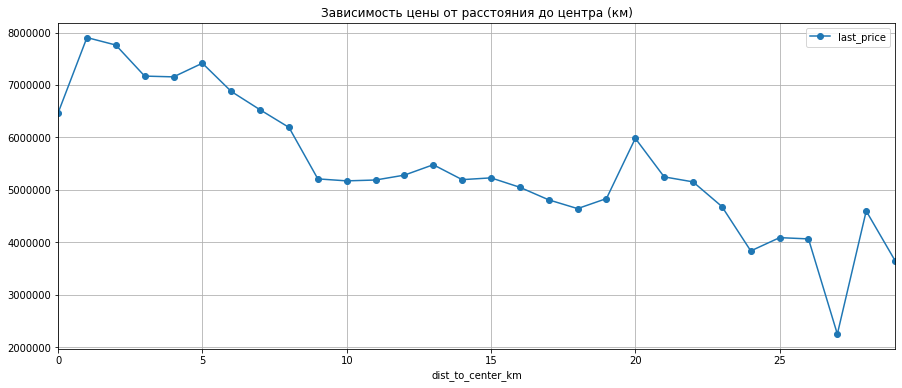

In [82]:
(df_spb
        .pivot_table(index='dist_to_center_km', values='last_price')
        .plot(title='Зависимость цены от расстояния до центра (км)', style='o-', grid=True, figsize=(15, 6))
);

На графике заметно резкое снижение средней стоимости квартир после 8 км от центра. Там и будет заканчиваться центр города.

Изучим сегмент квартир в центре Санкт-Петербурга. Выделим их в отдельный датасет, изучим параметры площади, цены, числа комнат, высоты потолков.

In [83]:
df_spb_center = df_spb.query('dist_to_center_km <= 8').reset_index(drop=True)
df_spb_center.head()

,total_images,last_price,total_area,publication_datetime,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balcony,locality_name,dist_to_airport,dist_to_center,parks_around3000,dist_to_park,ponds_around3000,dist_to_pond,publication_days,dist_to_center_km,price_per_meter,day_of_week,month,year,floor_cat,living_to_total_area,kitchen_to_total_area,publication_days_filt,last_price_filt,rooms_filt,ceiling_height_filt
0,8,6500000.0,97.2,2015-10-31,2,2.6,3.0,46.5,1,0,False,False,19.6,0.0,Санкт-Петербург,20052.0,2336.0,3.0,411.0,3.0,124.0,265.0,2,66872.4,5,10,2015,первый,0.5,0.2,False,False,False,False
1,9,3400000.0,30.0,2018-09-05,1,2.6,5.0,16.0,1,0,False,False,7.0,nan,Санкт-Петербург,39053.0,8313.0,1.0,382.0,0.0,nan,14.0,8,113333.3,2,9,2018,первый,0.5,0.2,False,False,False,False
2,3,3500000.0,29.5,2019-04-26,1,2.5,5.0,15.6,2,0,False,False,5.5,1.0,Санкт-Петербург,12921.0,7303.0,0.0,nan,0.0,nan,4.0,7,118644.1,4,4,2019,другой,0.5,0.2,False,False,False,False
3,32,9600000.0,90.0,2017-09-26,4,2.6,5.0,67.0,2,0,False,False,8.0,nan,Санкт-Петербург,23277.0,2818.0,0.0,nan,0.0,nan,104.0,3,106666.7,1,9,2017,другой,0.7,0.1,False,False,False,False
4,4,4590000.0,40.0,2017-05-29,1,2.6,6.0,18.0,1,0,False,False,10.0,0.0,Санкт-Петербург,20062.0,6175.0,1.0,241.0,0.0,nan,31.0,6,114750.0,0,5,2017,первый,0.5,0.2,False,False,False,False


In [84]:
df_spb_center[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,1473.0,1473.0,1473.0,1473.0
mean,60.5,6922036.4,2.1,2.7
std,22.1,2264040.0,1.0,0.1
min,12.0,1686000.0,0.0,2.4
25%,43.8,5150000.0,1.0,2.6
50%,58.0,6735600.0,2.0,2.6
75%,73.0,8580000.0,3.0,2.6
max,152.2,11866860.0,6.0,2.9


**Вывод**: Средние значения площади, стоимости квартир, высоты потолков в центре ожидаемо выше, чем в остальном городе. Среднее количество комнат везде одинаково.

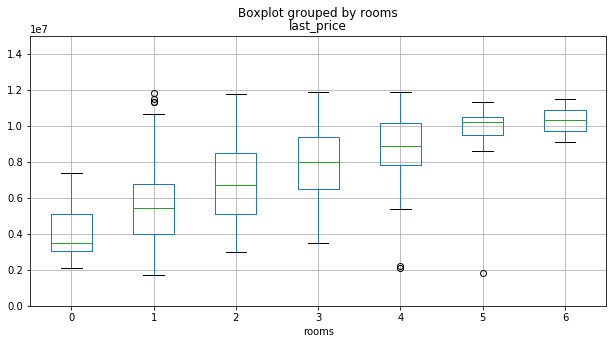

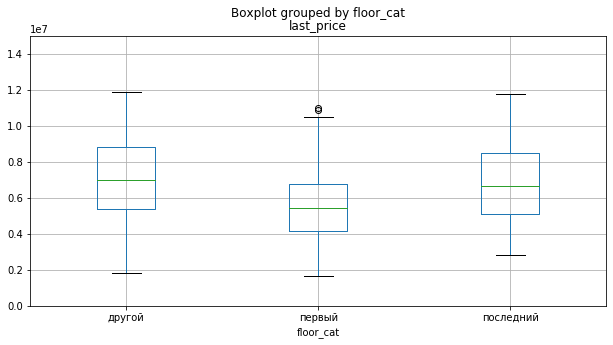

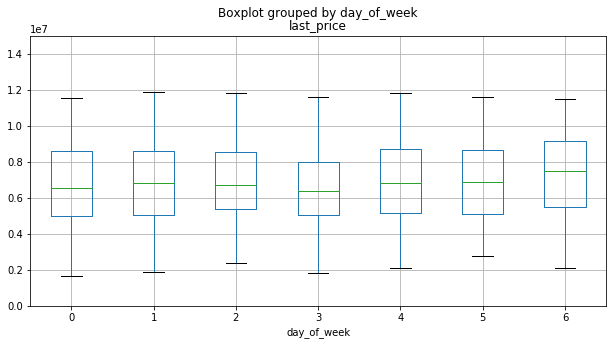

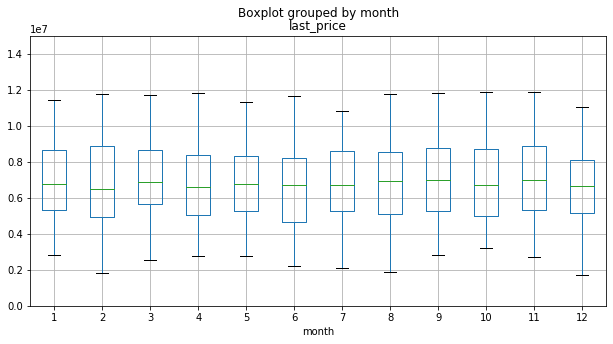

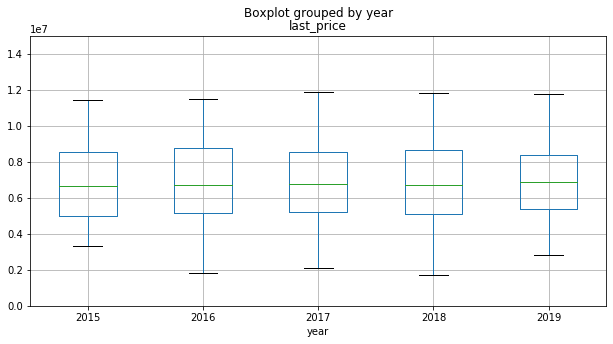

In [85]:
for column in ['rooms', 'floor_cat', 'day_of_week', 'month', 'year']:
    df_spb_center.boxplot('last_price', by=column, figsize=(10,5))
    plt.ylim(-500,15000000)    

Факторы, влияющие на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления), также не отличаются для недвижимости в центре и вне центра Санкт-Петербурга.

### Шаг 5. Общий вывод <a id="step5"></a>
[*Вернуться к плану*](#step0)

- На стоимость квартиры в Санкт-Петербурге и Лен. области влияют количество квадратных метров и комнат, близость к центру населенного пункта. Квартиры на первом и последних этажах дешевле. Стоимость квартиры не зависит от дня недели и месяца публикации объявления, но она коррелирует с годом публикации и, вероятно, макроэкономическими показателями в России.
- Самый высокая средняя цена недвижимости - в элитном поселке Лисий Нос, Санкт-Петербурге. В ближайших пригородах, где проживает большое количество петербуржцев, средняя цена также достаточно высокая. 
- В среднем квартира продается за 3 месяца. Быстрая продажа – 1,5 месяца, долгая – 8 и более.
- Жить вне 8-километрового центрального радиуса, значит жить не в центре города.
- Средние значения площади, стоимости квартир, высоты потолков в центре Санкт-Петербурга ожидаемо выше, чем в остальном городе. 
- Факторы, влияющие на стоимость квартиры, не отличаются для недвижимости в центре и вне центра Санкт-Петербурга.

**Рекомендации для платформы:**
- устранить причины появления пропусков и выбросов. Рекомендуется добавить категории в выпадающих списках;
- привести к соответствию типы данных параметров в столбцах;
- автоматизировать заполнение зависимых параметров.
